In [1]:
### from typing import Union
from collections import Counter

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data, flatten
from lib.ds.dataset_splitting import split_random, split_sequential
from lib.ds.torch_dataset import create_data_loader
from lib.ds.challenge_dataset import load_challenge_data
from lib.torch_generic_model_training import train_model_with_cv, train_model, evaluate_model
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model, save_model_with_scaler
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_final_epoch_of_folds, calculate_average_metrics_per_epoch, calculate_average_metrics
from lib.ds.bird_combiner import combine_birds
from lib.challenge import predict_for_challenge, save_results_to_csv, load_results_from_csv
from lib.label_fixing import fix_labels_information_gain
import lib.torch_device as tdev

from lib.loss.cost_matrix_loss import CostMatrixLoss
from lib.loss.cross_entropy_cost_matrix_loss import CrossEntropyCostMatrixLoss

from lib.model.combined_classifier import CombinedClassifier, CombinedClassifierHyperParameters
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.model.sliding_attention_classifier import SlidingAttentionClassifier, SlidingAttentionClassifierHyperParameters
from lib.model.cnn_classifier import CNNClassifier, CNNClassifierHyperParameters
from lib.model.cnn import ConvHyperParameters, CNNHyperParameters
from lib.model.fnn import FNN, FNNHyperParameters

%load_ext autoreload
%autoreload 2

In [2]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [3]:
data_raw, labels = load_all_data('dataset')
print(f'{data_raw.shape = }')
print(f'{labels.shape   = }')

data_raw.shape = (1200, 100, 548)
labels.shape   = (1200, 100)


In [4]:
test_size_pct = 0.2
random_test_splitting = False

if random_test_splitting:
    dataset_raw_train, dataset_raw_test = split_random(NumpyDataset(data_raw, labels), test_size_pct=test_size_pct, seed=69420666)
else:
    dataset_raw_train, dataset_raw_test = split_sequential(NumpyDataset(data_raw, labels), test_size_pct=test_size_pct)


print(f'{dataset_raw_train.data.shape = }')
print(f'{dataset_raw_test.data.shape  = }' if dataset_raw_test is not None else 'dataset_raw_test             = None')

print(f'{Counter(dataset_raw_train.labels.flatten().tolist()) = }')
print(f'{Counter(dataset_raw_test.labels.flatten().tolist())  = }' if dataset_raw_test is not None else '')

dataset_raw_train.data.shape = (960, 100, 548)
dataset_raw_test.data.shape  = (240, 100, 548)
Counter(dataset_raw_train.labels.flatten().tolist()) = Counter({0.0: 68551, 2.0: 7081, 3.0: 6515, 1.0: 4507, 5.0: 4093, 6.0: 3355, 4.0: 1898})
Counter(dataset_raw_test.labels.flatten().tolist())  = Counter({0.0: 16807, 2.0: 1873, 3.0: 1683, 1.0: 1326, 5.0: 1018, 6.0: 867, 4.0: 426})


### Create sequences

In [5]:
sequences_ds_train = combine_birds(
    dataset_raw_train, 
    sequence_length=300,
    random_seed=42
)
print(f'{sequences_ds_train.data.shape   = }')
print(f'{sequences_ds_train.labels.shape = }\n\n')


sequences_ds_test = combine_birds(
    dataset_raw_test, 
    sequence_length=300,
    random_seed=42
)

if sequences_ds_test is not None:
    print(f'{sequences_ds_test.data.shape   = }')
    print(f'{sequences_ds_test.labels.shape = }')
else:
    print('sequences_ds_test = None')

Creating random sequence (num_duplicates = 1): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96000/96000 [01:21<00:00, 1184.72it/s]


sequences_ds_train.data.shape   = (320, 300, 548)
sequences_ds_train.labels.shape = (320, 300)




Creating random sequence (num_duplicates = 1): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24000/24000 [00:05<00:00, 4460.79it/s]

sequences_ds_test.data.shape   = (80, 300, 548)
sequences_ds_test.labels.shape = (80, 300)


# Hyper Parameters

In [6]:
ac_hyper_parameters = AttentionClassifierHyperParameters(
    in_features=data_raw.shape[-1],
    out_features=NUM_CLASSES,
    
    # attention_window_size=300,
    # step=6,
    
    d_model=48,
    num_heads=8,
    attention_stack_size=1,
    attention_stack_activation_provider=lambda: nn.LeakyReLU(),
    attention_dropout=0.4,
    
    in_linear_hidden_out_features=[48, 48],
    out_linear_hidden_out_features=[24, 16],
    linear_activation_provider=lambda: nn.LeakyReLU(),
    linear_dropout=0.4,
    
    add_residual=True,
)

In [4]:
cnn_hyper_parameters = CNNClassifierHyperParameters(
    
    in_fnn_hyper_parameters=FNNHyperParameters(
        in_features=data_raw.shape[-1],
        layers_out_features=[48, 48],
        dropout=0.45,
        activation_provider=lambda: nn.LeakyReLU()
    ),
    
    cnn1d_embedding_hyper_parameters=FNNHyperParameters(
        in_features=48,
        layers_out_features=[32, 32],
        dropout=0.45,
        activation_provider=lambda: nn.LeakyReLU()
    ),
    
    cnn1d_hyper_parameters=CNNHyperParameters(
        in_channels=32,

        layers_hyper_parameters=[
            ConvHyperParameters(out_channels=32, kernel_size=3, stride=1, dilation=1, groups=1, bias=False, padding='same'),
            ConvHyperParameters(out_channels=32, kernel_size=3, stride=1, dilation=1, groups=1, bias=False, padding='same'),
        ],

        normalize_before=False,
        normalize_after=True,

        activation_provider=lambda: nn.LeakyReLU(),
        
        dropout=0.45
    ),
    
    
    cnn2d_embedding_hyper_parameters=FNNHyperParameters(
        in_features=48,
        layers_out_features=[32, 32],
        dropout=0.45,
        activation_provider=lambda: nn.LeakyReLU()
    ),
    
    cnn2d_hyper_parameters=CNNHyperParameters(
        in_channels=1,

        layers_hyper_parameters=[
            ConvHyperParameters(out_channels=32, kernel_size=(5, 5), stride=(1, 1), dilation=(1, 1), groups=1, bias=False, padding='same'),
            ConvHyperParameters(out_channels=16, kernel_size=(3, 3), stride=(1, 1), dilation=(1, 1), groups=1, bias=False, padding='same'),
            ConvHyperParameters(out_channels=1, kernel_size=(3, 3), stride=(1, 1), dilation=(1, 1), groups=1, bias=False, padding='same'),
        ],

        normalize_before=False,
        normalize_after=True,

        activation_provider=lambda: nn.LeakyReLU(),
        
        dropout=0.45
    ),
    
    
    out_fnn_hyper_parameters=FNNHyperParameters(
        in_features=32 + 32,
        layers_out_features=[48, NUM_CLASSES],
        dropout=0.45,
        activation_provider=lambda: nn.LeakyReLU()
    ),
)

In [102]:
combined_hyper_parameters = CombinedClassifierHyperParameters(
    
    cnn_classifier_hyper_parameters=CNNClassifierHyperParameters(
    
        cnn1d_embedding_hyper_parameters=FNNHyperParameters(
            in_features=data_raw.shape[-1],
            layers_out_features=[32, 32],
            dropout=0.45,
            activation_provider=lambda: nn.LeakyReLU()
        ),

        cnn1d_hyper_parameters=CNNHyperParameters(
            in_channels=32,

            layers_hyper_parameters=[
                ConvHyperParameters(out_channels=32, kernel_size=3, stride=1, dilation=1, groups=1, bias=False, padding='same'),
                ConvHyperParameters(out_channels=32, kernel_size=3, stride=1, dilation=1, groups=1, bias=False, padding='same'),
            ],

            normalize_before=False,
            normalize_after=True,

            activation_provider=lambda: nn.LeakyReLU(),

            dropout=0.45
        ),


        cnn2d_embedding_hyper_parameters=FNNHyperParameters(
            in_features=data_raw.shape[-1],
            layers_out_features=[32, 32],
            dropout=0.45,
            activation_provider=lambda: nn.LeakyReLU()
        ),

        cnn2d_hyper_parameters=CNNHyperParameters(
            in_channels=1,

            layers_hyper_parameters=[
                ConvHyperParameters(out_channels=32, kernel_size=(5, 5), stride=(1, 1), dilation=(1, 1), groups=1, bias=False, padding='same'),
                ConvHyperParameters(out_channels=16, kernel_size=(3, 3), stride=(1, 1), dilation=(1, 1), groups=1, bias=False, padding='same'),
                ConvHyperParameters(out_channels=1, kernel_size=(3, 3), stride=(1, 1), dilation=(1, 1), groups=1, bias=False, padding='same'),
            ],

            normalize_before=False,
            normalize_after=True,

            activation_provider=lambda: nn.LeakyReLU(),

            dropout=0.45
        ),


        out_fnn_hyper_parameters=FNNHyperParameters(
            in_features=32 + 32,
            layers_out_features=[48],
            dropout=0.45,
            activation_provider=lambda: nn.LeakyReLU()
        ),
    ),
    
    
    attention_classifier_hyper_parameters=AttentionClassifierHyperParameters(
        in_features=48,
        out_features=NUM_CLASSES,

        # attention_window_size=300,
        # step=6,

        d_model=48,
        num_heads=8,
        attention_stack_size=0,
        attention_stack_activation_provider=lambda: nn.LeakyReLU(),
        attention_dropout=0.4,

        in_linear_hidden_out_features=[48],
        out_linear_hidden_out_features=[24, 16],
        linear_activation_provider=lambda: nn.LeakyReLU(),
        linear_dropout=0.4,

        add_residual=True,
    ),
)

TypeError: __init__() missing 1 required positional argument: 'in_fnn_hyper_parameters'

#### Training HP

In [5]:
training_gain_matrix = np.array([
    [ 0.05, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2],
    [-0.25,   1., -0.3, -0.1, -0.1, -0.1, -0.1],
    [-0.02, -0.1,   1., -0.1, -0.1, -0.1, -0.1],
    [-0.25, -0.1, -0.3,   1., -0.1, -0.1, -0.1],
    [-0.25, -0.1, -0.3, -0.1,   1., -0.1, -0.1],
    [-0.25, -0.1, -0.3, -0.1, -0.1,   1., -0.1],
    [-0.25, -0.1, -0.3, -0.1, -0.1, -0.1,   1.],
])

training_gain_matrix += np.array([
    [  0.00,  0.00,  0.00, -0.15,  0.00,  0.00,  0.00],
    [  0.00,  0.00,  0.00, -1.00,  0.00,  0.00,  0.00],
    [  0.00,  0.00,  0.00, -0.50,  0.00,  0.00,  0.00],
    [  0.00,  0.00,  0.00, -0.15,  0.00,  0.00,  0.00],
    [  0.00,  0.00,  0.00, -0.15,  0.00,  0.00,  0.00],
    [ -0.50,  0.00,  0.00, -0.15,  0.00,  0.00,  0.00],
    [  0.00,  0.00,  0.00, -0.15,  0.00,  0.00,  0.00],
])

In [10]:
training_hyper_parameters = TrainingHyperParameters(
    batch_size=64,

    loss_module_provider=lambda balancing_loss_weights: CrossEntropyCostMatrixLoss(
        cross_entropy_loss=nn.CrossEntropyLoss(weight=balancing_loss_weights),
        cross_entropy_weight=0.0,
        
        cost_matrix_loss=CostMatrixLoss(torch.Tensor(training_gain_matrix), is_gain_matrix=True),
        cost_matrix_weight=1.0,
    ),

    optimizer_provider=lambda model, lr: optim.Adamax(
        model.parameters(),
        lr=lr,
        betas=(0.9, 0.98),
        eps=1e-9,
        weight_decay=1e-4,
    ),

    num_epochs=1000,
    lr=5e-2,

    lr_scheduler_milestones=[int(m) for m in [30, 100, 250]],
    lr_scheduler_gamma=0.75,
    lr_scheduler_provider=lambda optimizer, milestones, gamma: None,
    # lr_scheduler_provider=lambda optimizer, milestones, gamma: lr_scheduler.MultiStepLR(
    #     optimizer, 
    #     milestones=milestones,
    #     gamma=gamma
    # )
)

# Training

## Cross Validation

Creating 8 folds


CV Folds:   0%|                                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]




Executing CV for fold 0
Training fold 0


#### Training ####
##################
CNNClassifier with 49465 parameters: 
in_fnn:                28704, 
conv1d_embedding:       2624, 
conv2d_embedding:       2624, 
conv1d_layers:          6272, 
conv2d_layers:          5650, 
out_fnn:                3463, 

##################

train label counts = [60115,  4032,  5980,  5621,  1668,  3753,  2831]
eval label counts  = [ 8436,   475,  1101,   894,   230,   340,   524]

balancing loss weights                    = [ 1.00, 14.91, 10.05, 10.69, 36.04, 16.02, 21.23]
balancing eval loss weights (theoretical) = [ 1.00, 17.76,  7.66,  9.44, 36.68, 24.81, 16.10]


Training Epoch   1/1000: lr = 1.00E-02, epoch =     1, avg_loss = 0.000022, num_samples = 84000, num_correct = 36775, acc = 0.437798, bacc = 0.183865, score = -0.147984
Evaluation Epoch   1/1000: epoch =     1, avg_loss = 0.000150, num_samples = 12000, num_correct =  5143, acc = 0.428583, bacc = 0.223386, score = -0.130747
Training Epoch

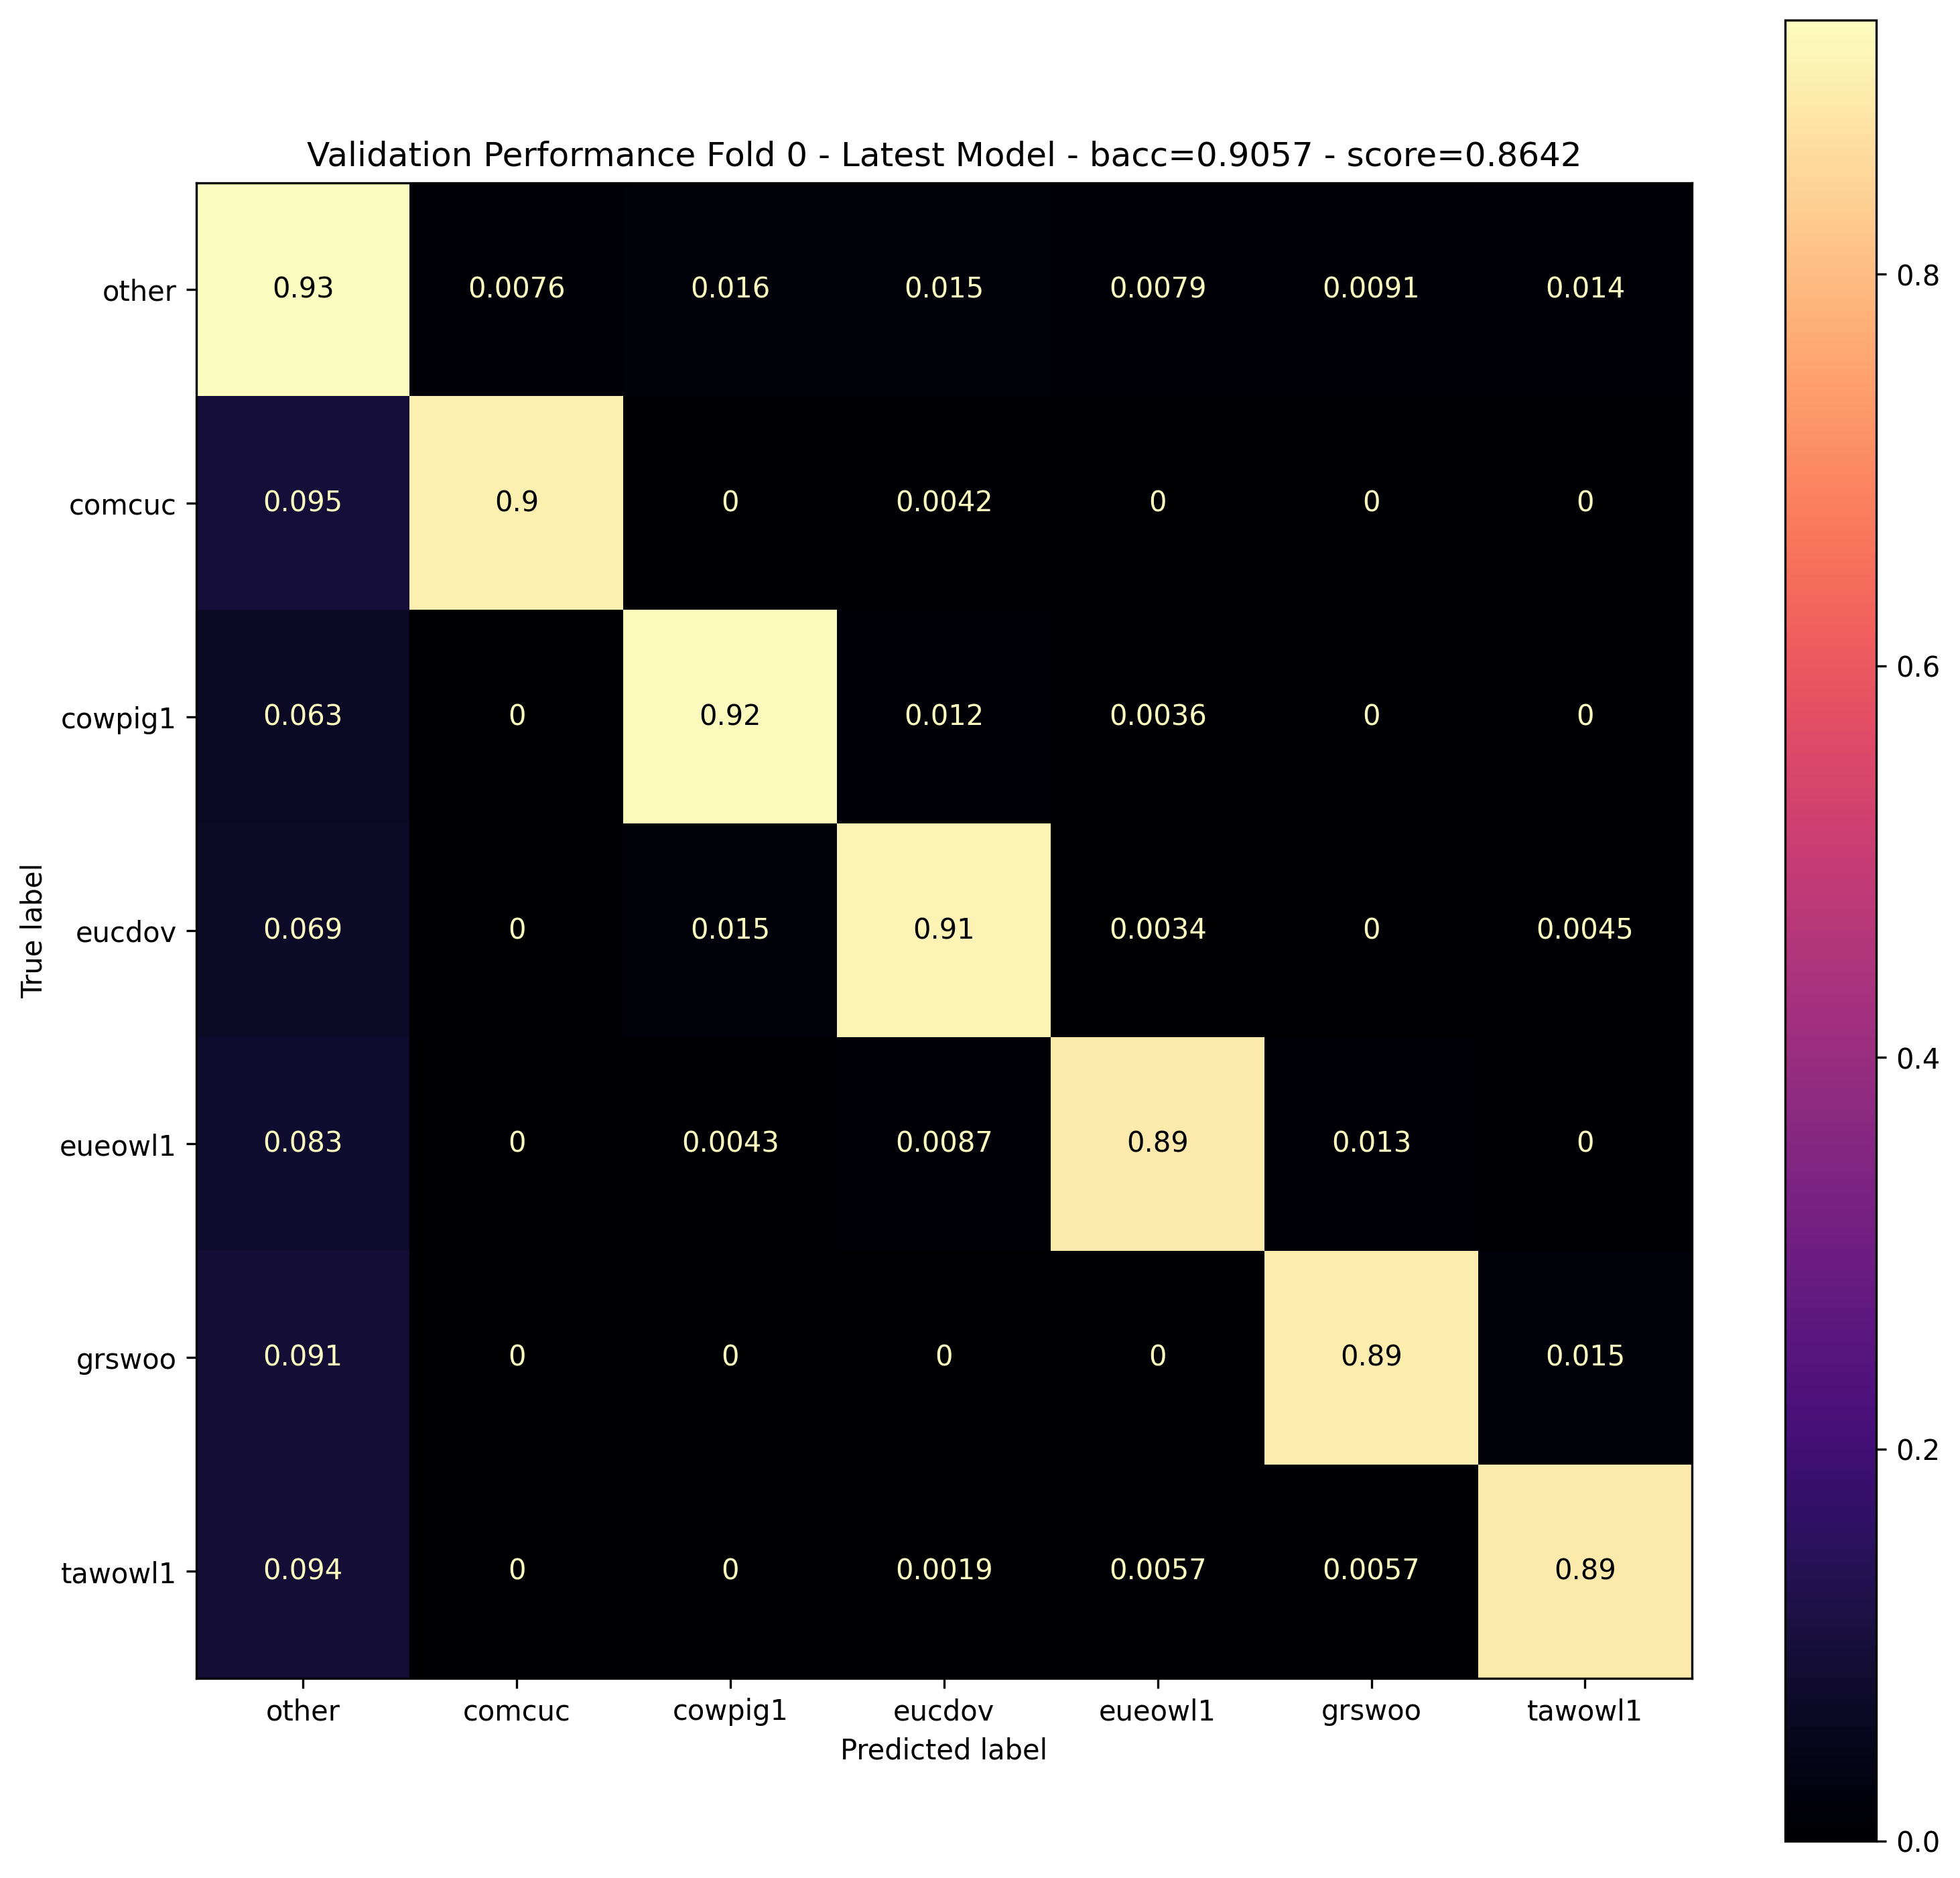

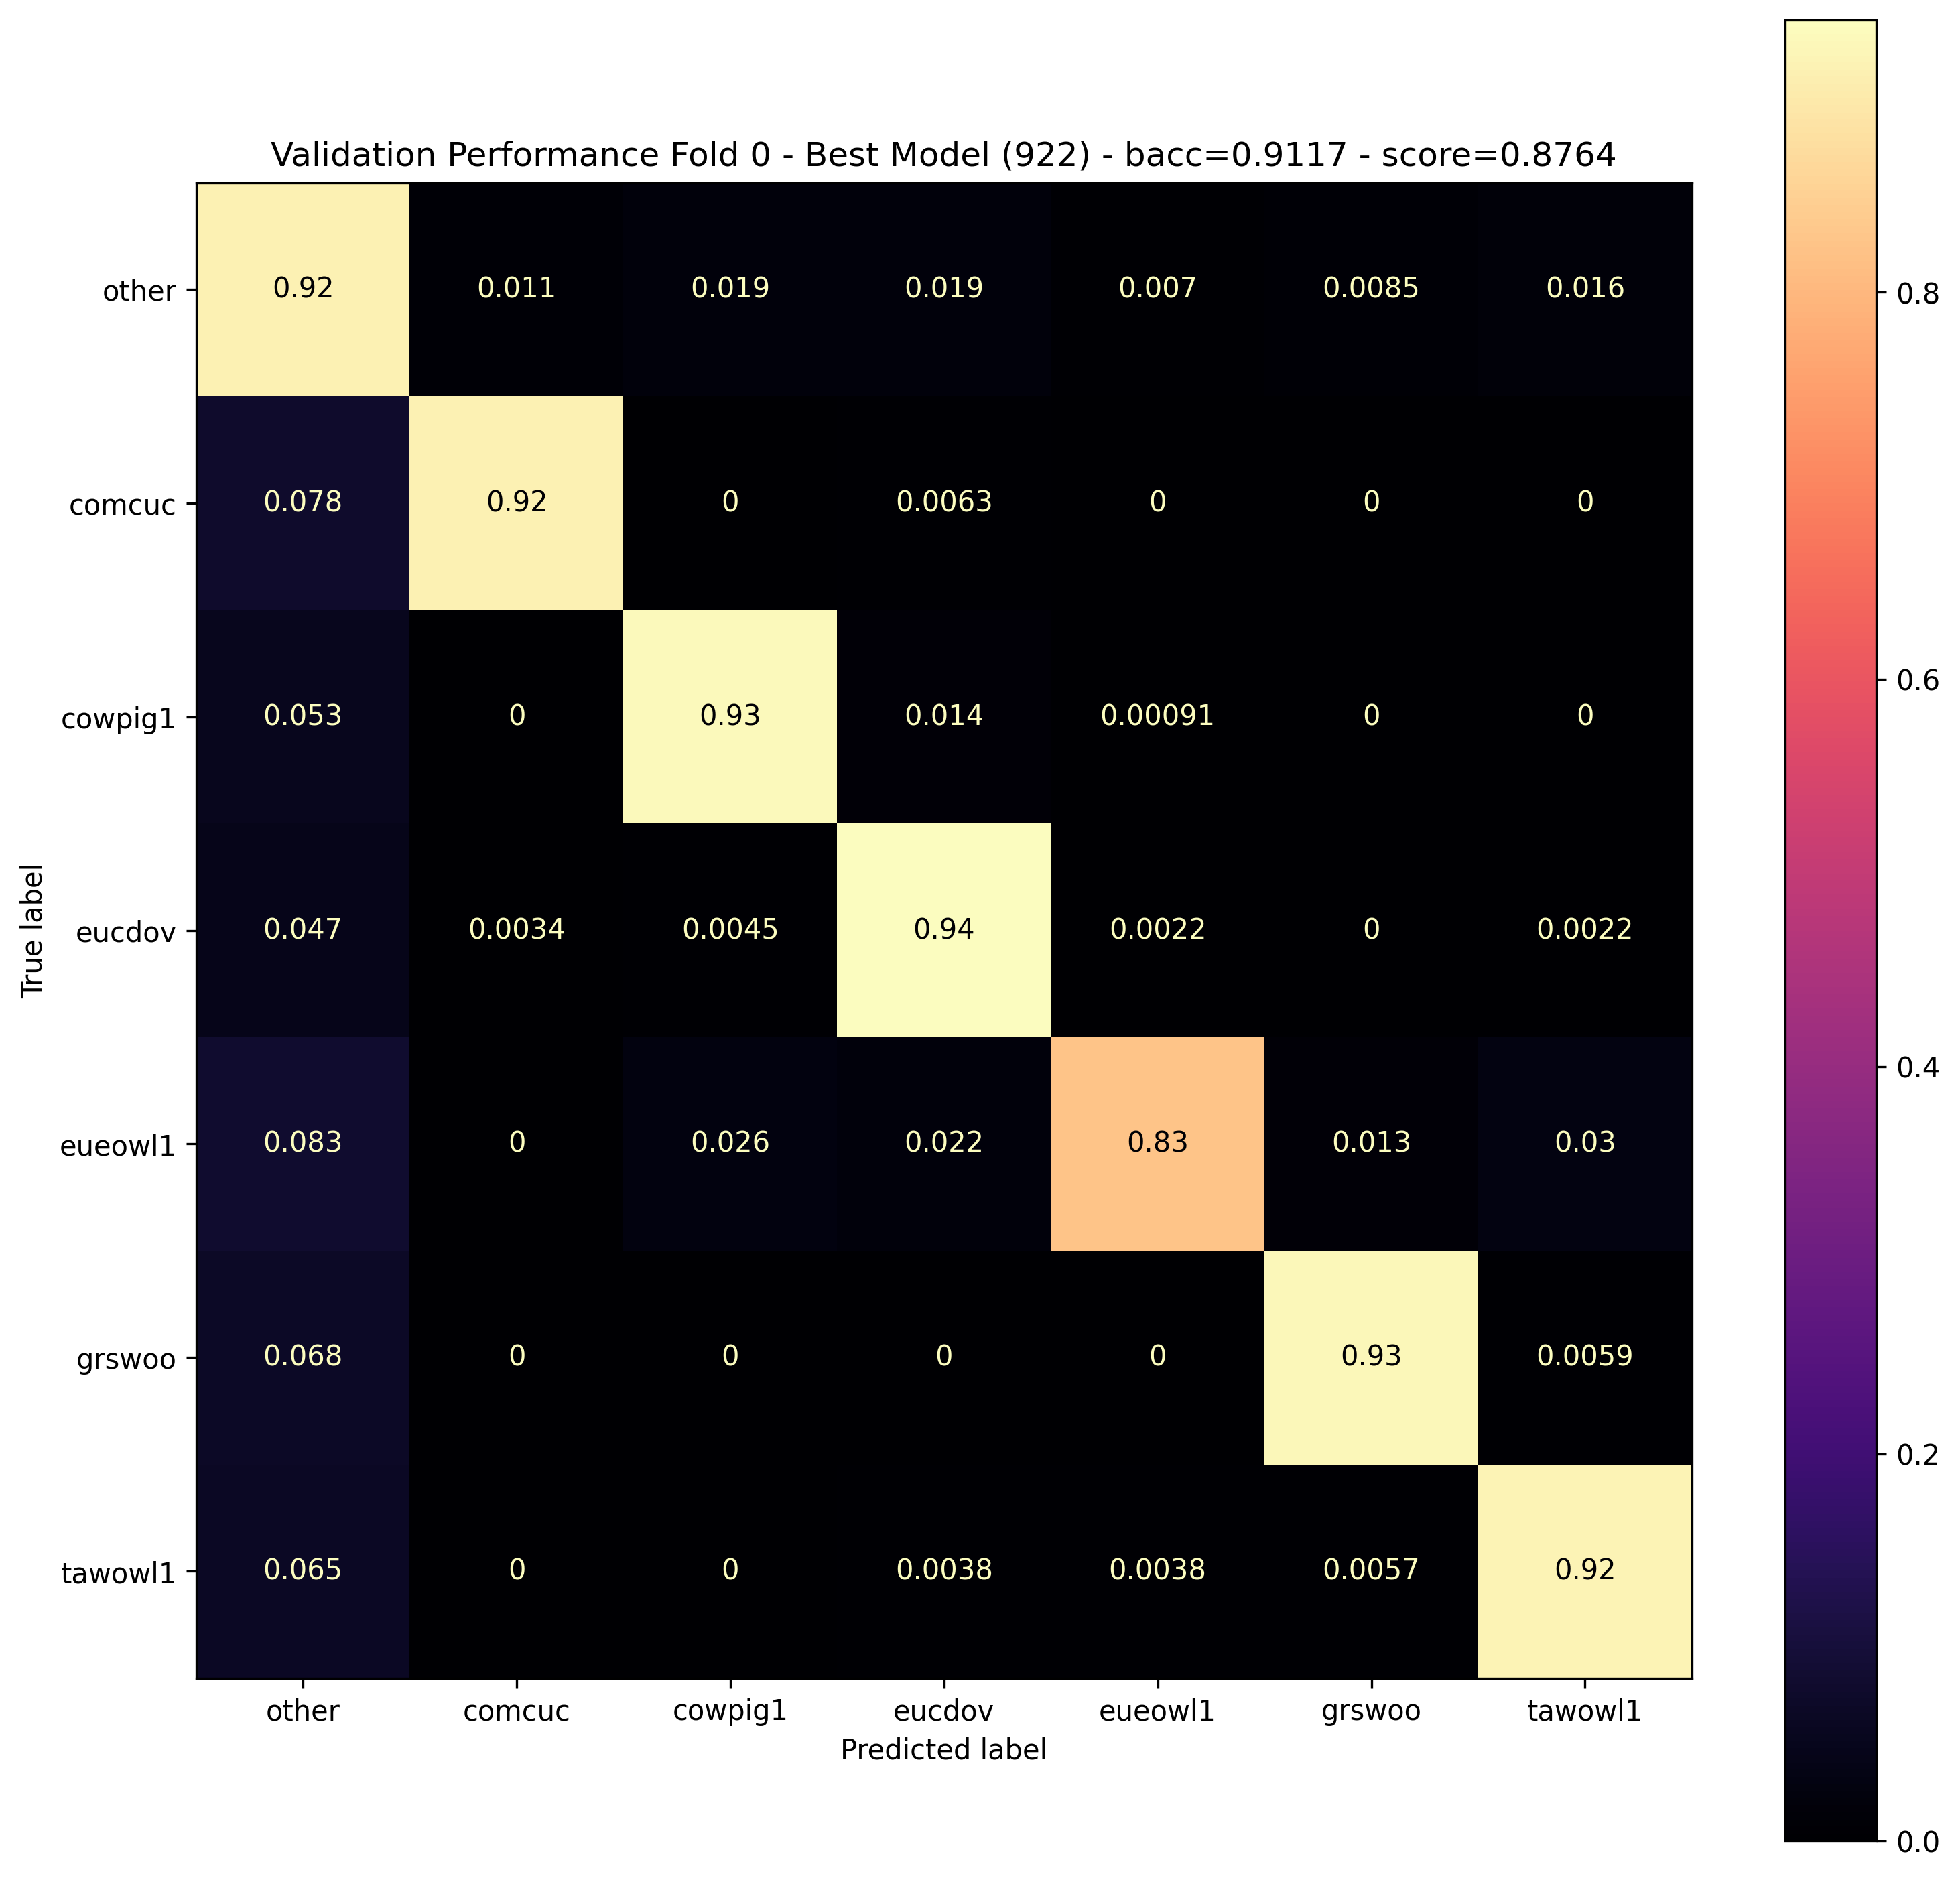


Testing fold 0


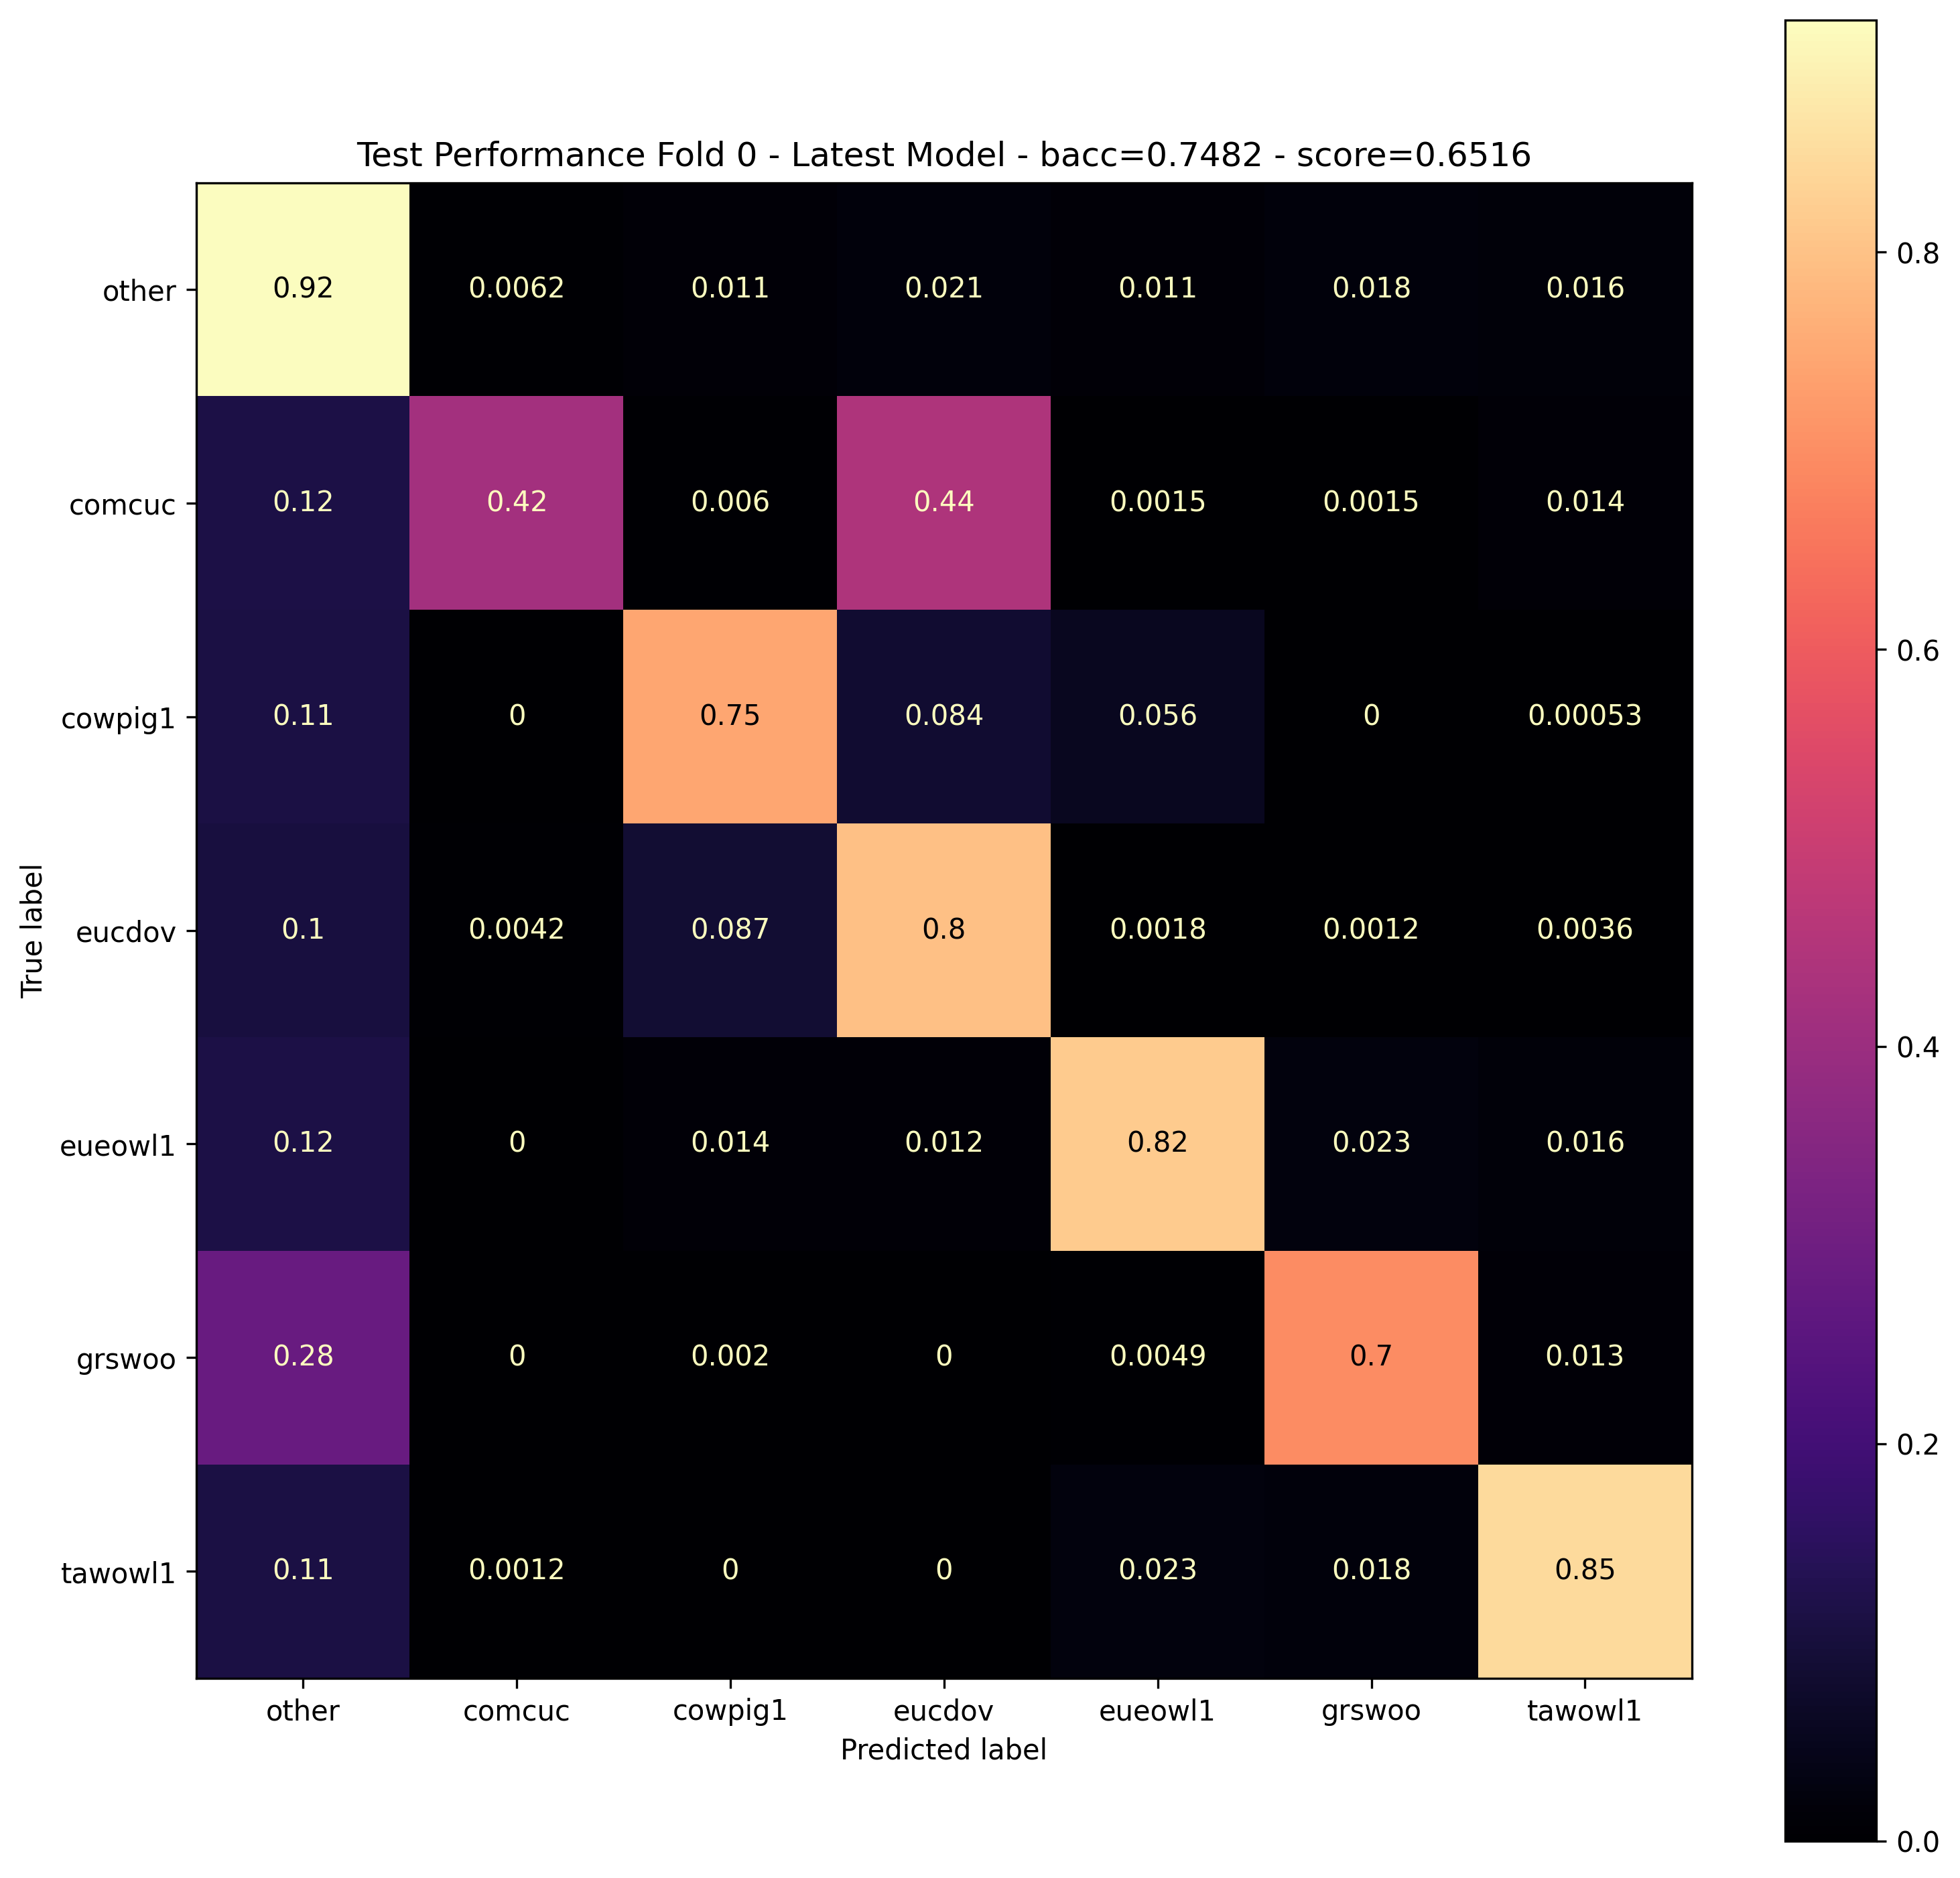

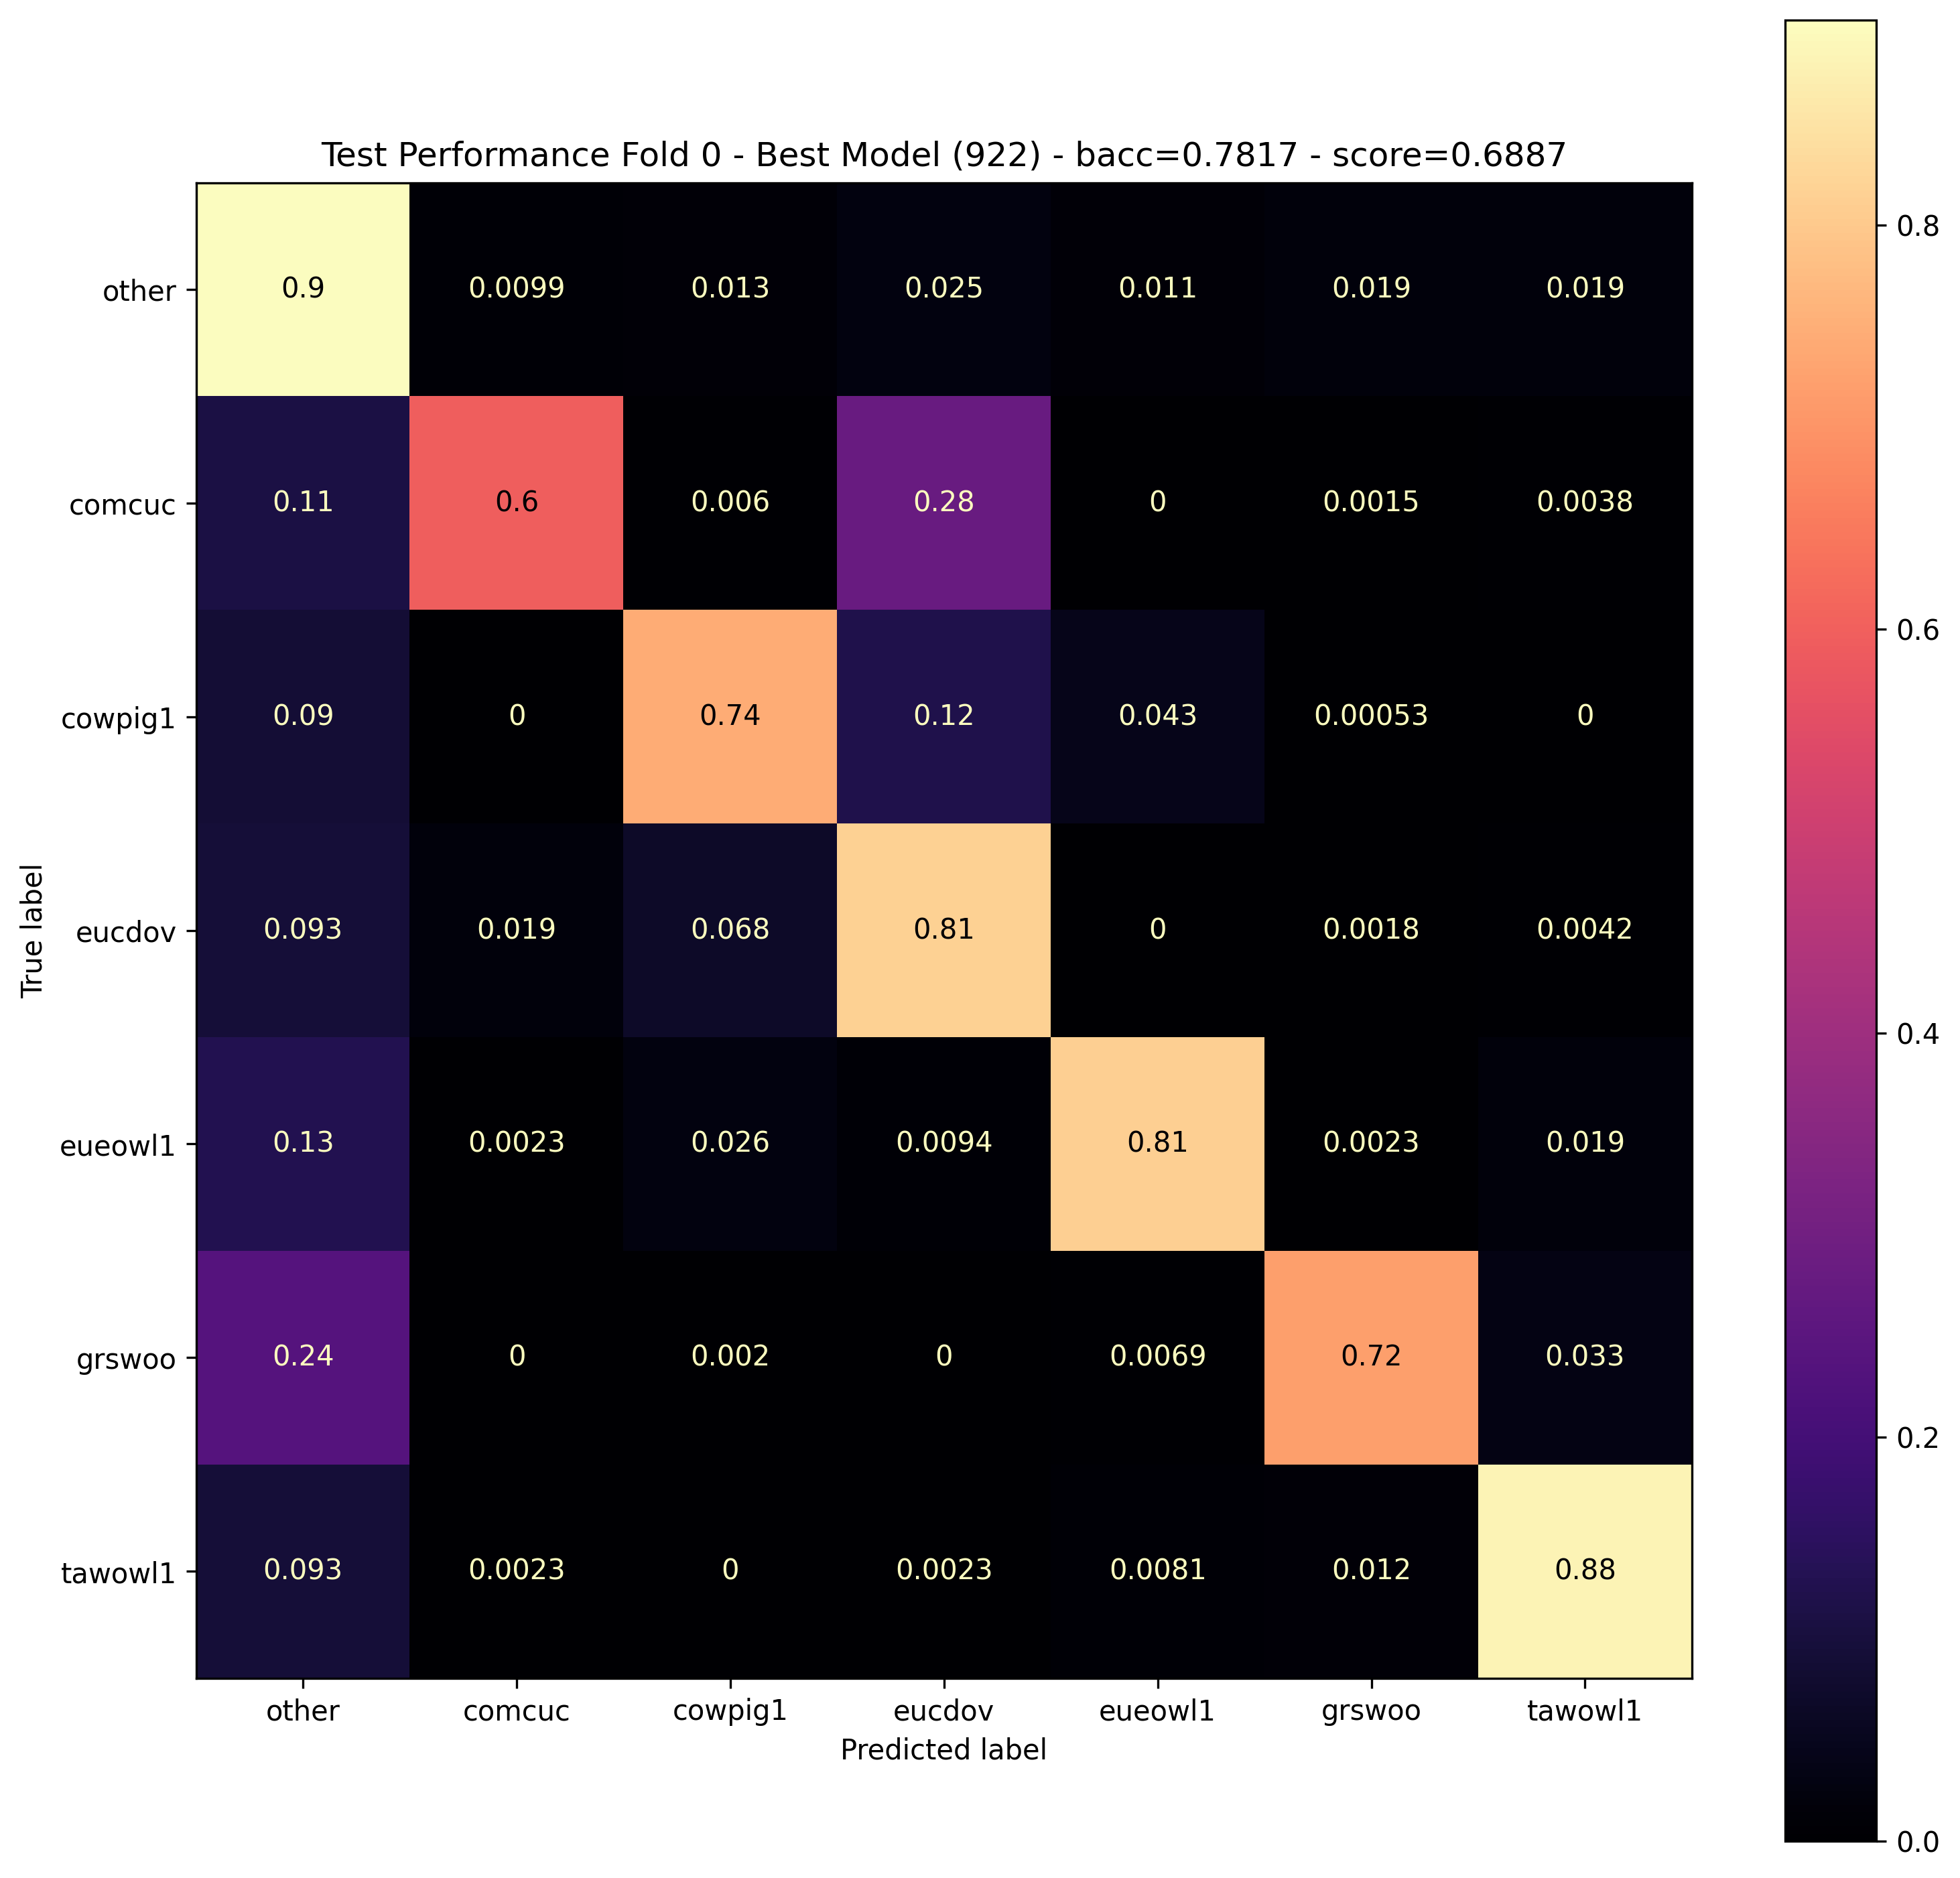

CV Folds:   0%|                                                                                                                                                                                                                     | 0/8 [03:35<?, ?it/s]

Best Model Test Metrics: epoch =    -1, avg_loss = 0.004085, num_samples = 24000, num_correct = 20553, acc = 0.856375, bacc = 0.781747, score = 0.688696


PicklingError: Can't pickle <class 'lib.model.cnn_classifier.CNNClassifier'>: it's not the same object as lib.model.cnn_classifier.CNNClassifier

In [112]:
set_random_seed(420)

cv_models_with_scalers, cv_folds_metrics, best_models_metrics = train_model_with_cv(
    lambda: CNNClassifier(cnn_hyper_parameters),
    #lambda: AttentionClassifier(ac_hyper_parameters, batch_first=True),
    #lambda: CombinedClassifier(combined_hyper_parameters),
    training_hyper_parameters, 
    sequences_ds_train,
    sequences_ds_test,
    n_folds=8,
    device=device,
    save_models='both',
    model_saving_name='species_classifier',
)


## Metrics ##
print(
'''

#################
#### Metrics ####
#################

'''
)

cv_average_best_best_models_eval_metrics = calculate_average_metrics([m[1] for m in best_models_metrics])
print(f'{cv_average_best_best_models_eval_metrics = } \n\n')

if best_models_metrics[0][2] is not None:
    cv_average_best_best_models_test_metrics = calculate_average_metrics([m[2] for m in best_models_metrics])
    print(f'{cv_average_best_best_models_test_metrics = } \n\n')

cv_avg_epoch_train_metrics = calculate_average_metrics_per_epoch(cv_folds_metrics)

rows = []
for fold_nr, fold_metrics in enumerate(cv_folds_metrics):
    for epoch_nr, (train_metrics, eval_metrics) in enumerate(fold_metrics):
        rows.append({
            'cv_fold': fold_nr,
            'epoch': epoch_nr,
            'type': 'CV Train BACC',
            'bacc': train_metrics.bacc,
        })
        if eval_metrics is not None:
            rows.append({
                'cv_fold': fold_nr,
                'epoch': epoch_nr,
                'type': 'CV Eval BACC',
                'bacc': eval_metrics.bacc,
            })

cv_metrics_df = pd.DataFrame(rows)

## Full Train

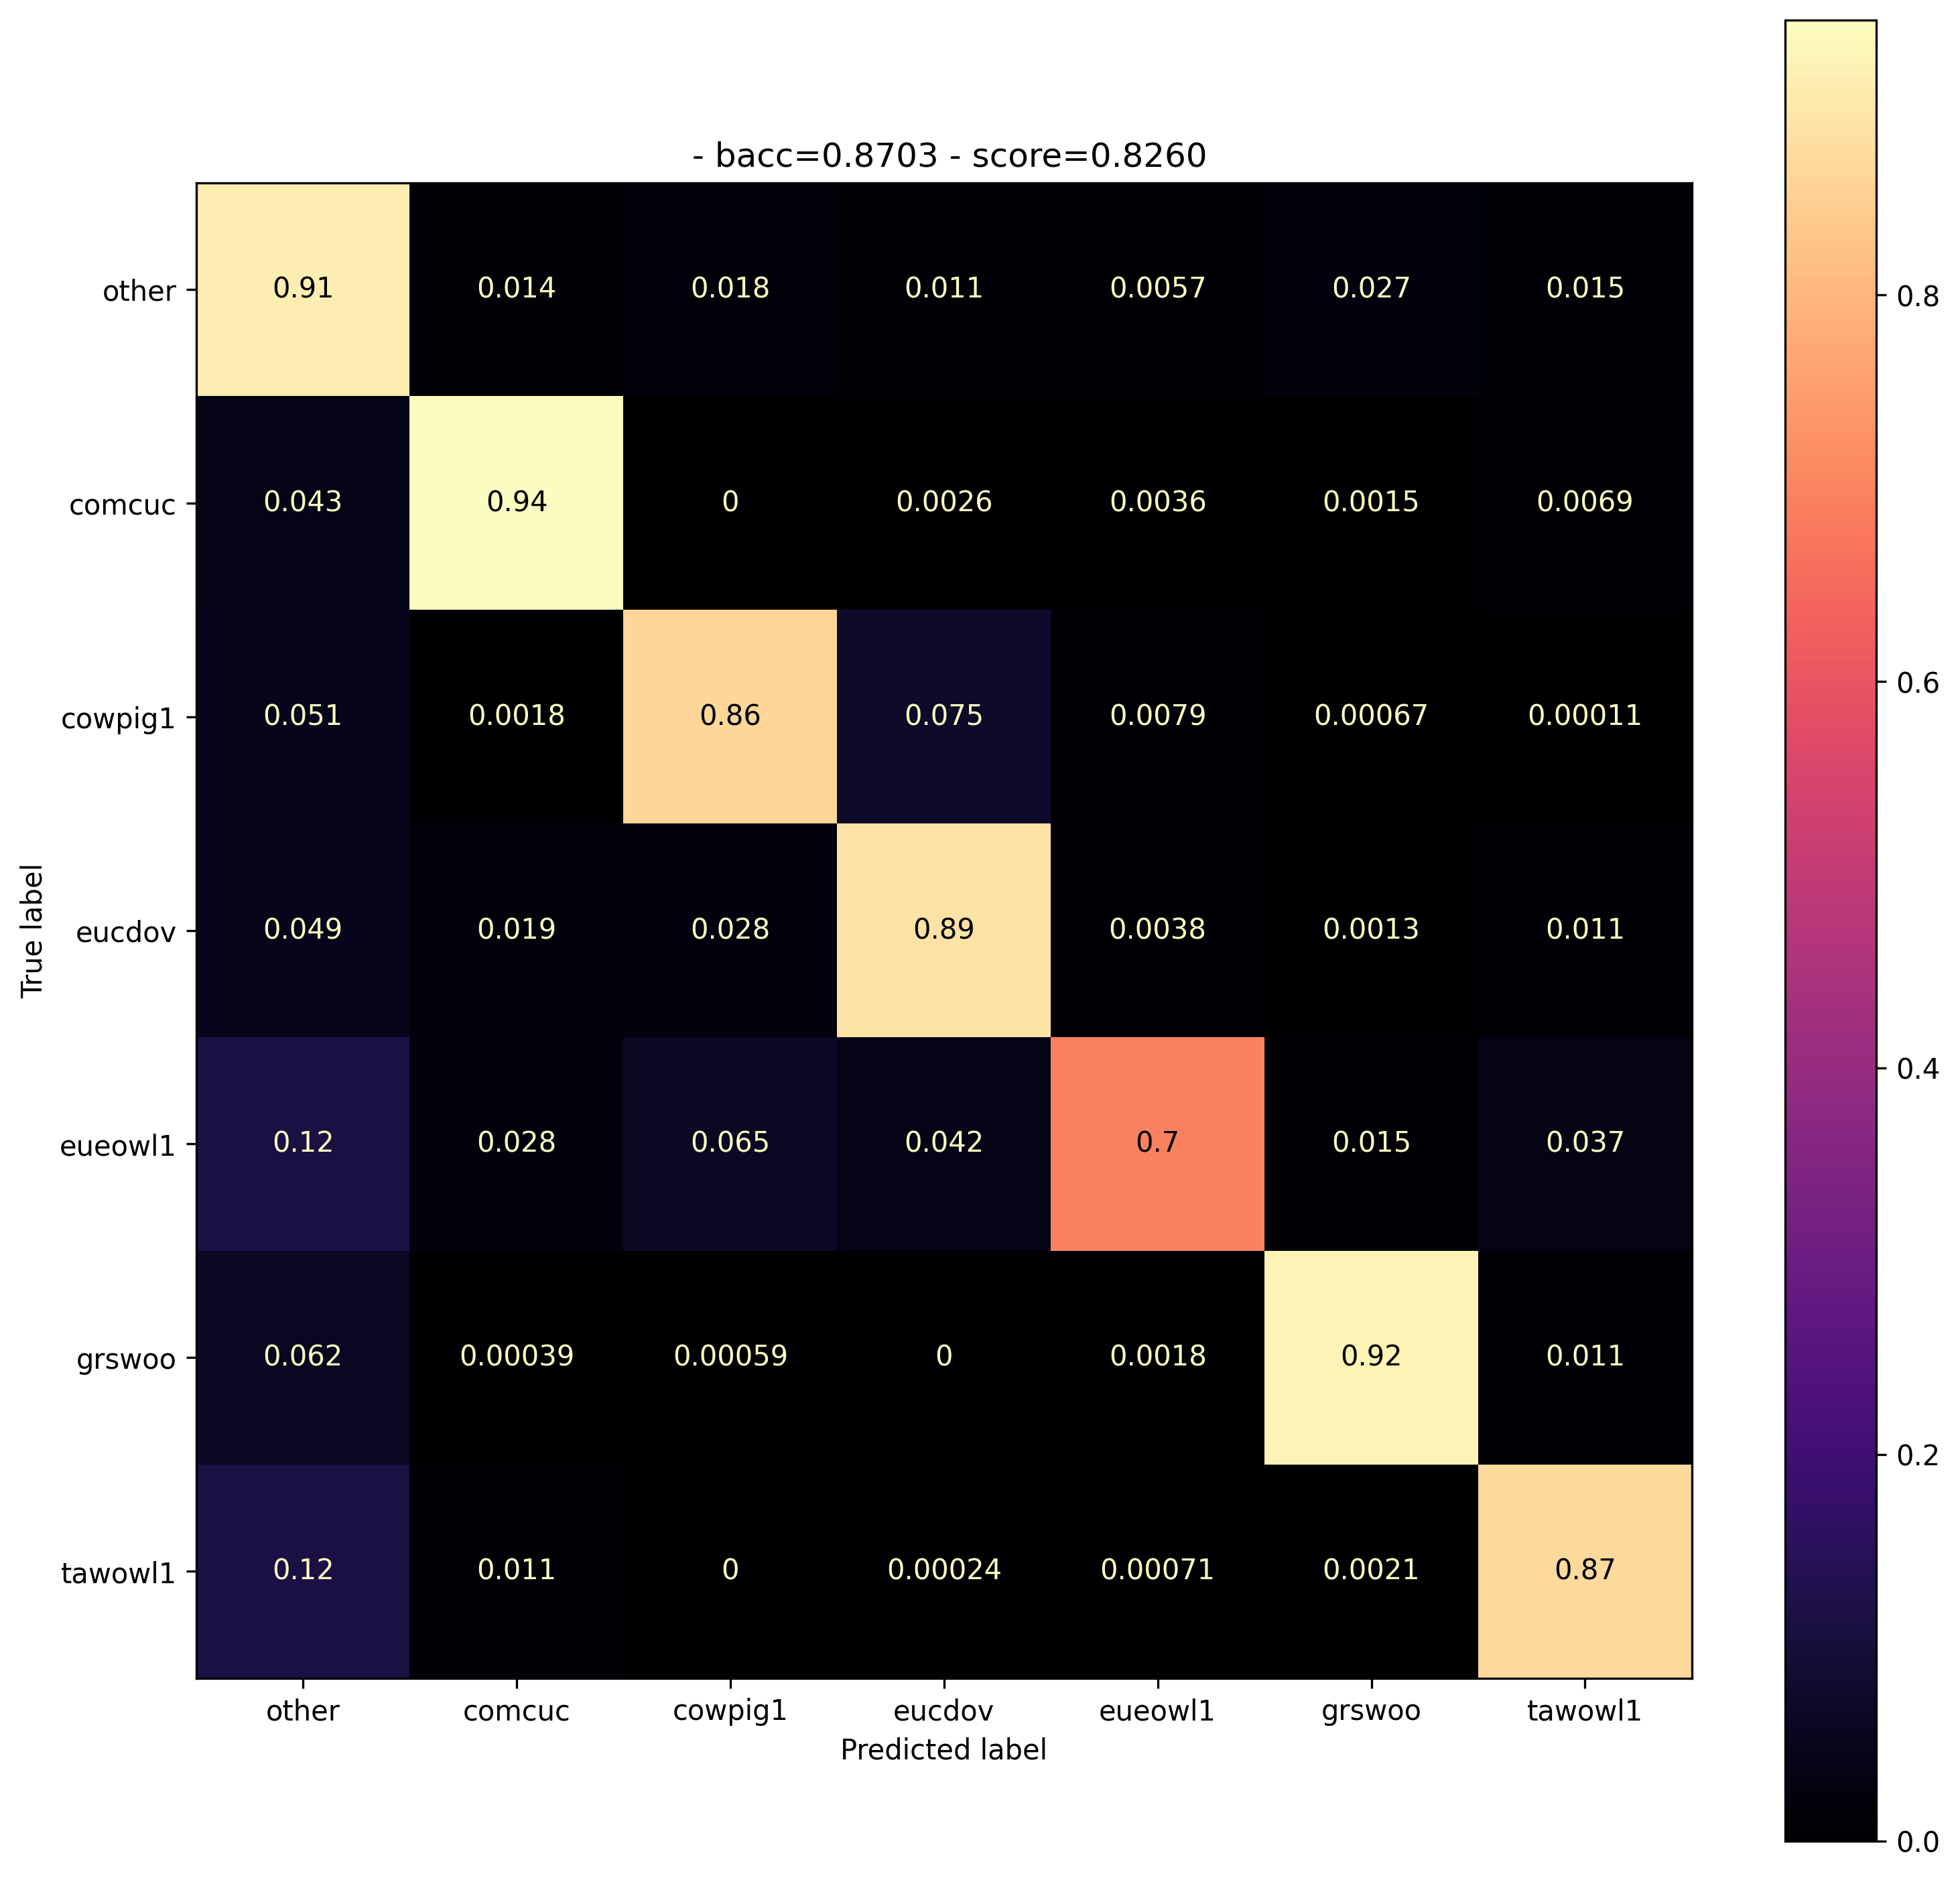

Saved model with scaler as "species_classifier full2023-06-19_02.00"


In [12]:
set_random_seed(43)

# sequences_data_train_normalized, _, sequences_ds_train_normalization_scaler = normalize_data(sequences_ds_train.data, None)
# 
# sequences_ds_train_normalized = sequences_ds_train.copy()
# sequences_ds_train_normalized.data = sequences_data_train_normalized

data_raw_normalized, _, data_raw_normalization_scaler = normalize_data(data_raw, None)
data_raw_normalized_ds = NumpyDataset(data_raw_normalized, labels)

# fully_trained_model, metrics, _, _ = train_model(
#     CNNClassifier(cnn_hyper_parameters),
#     training_hyper_parameters,
#     data_raw_normalized_ds,
#     data_raw_normalized_ds,
#     device
# )

evaluate_model(
    fully_trained_model, 
    create_data_loader(data_raw_normalized_ds.data, data_raw_normalized_ds.labels, 32, False), 
    device, 
    show_confmat=True, 
    confmat_title=''
)

save_model_with_scaler(fully_trained_model, data_raw_normalization_scaler, 'species_classifier full2023-06-19_02.00')

# Plots

In [ ]:
def create_lrs_over_epochs(training_hyper_parameters: TrainingHyperParameters) -> list[float]:
    lrs: list[float] = []
    
    lr = training_hyper_parameters.lr
    for epoch_nr in range(training_hyper_parameters.num_epochs):
        if epoch_nr in training_hyper_parameters.lr_scheduler_milestones:
            lr *= training_hyper_parameters.lr_scheduler_gamma
        lrs.append(lr)
    return lrs
    

def plot_baccs_over_epochs(title: str):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
    
    cv_epoch_range = np.arange(0, training_hyper_parameters.num_epochs)
    
    sns.lineplot(data=cv_metrics_df, x='epoch', y='bacc', hue='type', ax=ax, palette=['blue', 'green'])
    
    twin_ax = ax.twinx()
    lr_plots_kwargs = {
        'ls': '--',
        'lw': 0.75
    }
    twin_ax.plot(cv_epoch_range, create_lrs_over_epochs(training_hyper_parameters), label='CV LR', c='lightblue', **lr_plots_kwargs)

    ax.set(
        title=title,
        xlabel='Epoch',
        ylabel='BACC',
        yticks=[x * 0.1 for x in range(11)]
    )

    ax.grid(ls=':')
    ax.legend(loc='center right')
    twin_ax.legend(loc='lower right')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
        twin_ax.spines[spine].set_visible(False)

    plt.show()

average_last_epoch_eval_bacc = cv_metrics_df.query('type == "CV Eval BACC"').groupby('epoch').mean().iloc[-1]['bacc']
plot_baccs_over_epochs(f'Attention Classifier, last epoch eval bacc = {average_last_epoch_eval_bacc:6f}')